## Filtrado Anistropico 

Índice de los pasos a seguir:
* Importamos las librerías 
* Cargamos las imágenes
* Primera visualización de imágenes 
* Elección del corte de la imagen
* Aplicación de ruido a la imagen
* Aplicación del filtro anisotrópico 
* Evaluación del filtro anisotrópico con el script de aula virtual 

### 1. Importamos las liberias necesarias para los algoritmos.

In [2]:
import os
import numpy as np
import nibabel as nib #nos permite leer las imagenes
import matplotlib 
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
import modules
from nilearn import plotting

### 2. Importamos las imágenes con la libreria nibabel para leer nuestras imagenes en formato NIFTI

In [3]:
img = nib.load(r'\Users\Maria\Desktop\data\sub-01\anat\sub-01_T1w.nii.gz')
img2 = nib.load(r'\Users\Maria\Desktop\data\sub-17\anat\sub-17_T1w.nii.gz')

In [4]:
#para obtener los datos de nuestra imagen
data = img.get_fdata()

In [5]:
#nos muestra las dimensiones de nuestra imagen
print(data.shape) 

(176, 256, 256)


### 3. Visualizamos nuestras imagenes con un plot

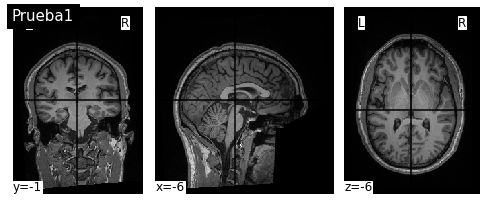

In [7]:
plotting.plot_img(img, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()   

Redimensionamos las imágenes, porque de no hacerlo tardarían varias horas a la hora de ejecutar el algoritmo. 

In [8]:
#Redimensionamos las imágenes

a = np.array(skimage.transform.resize(img.dataobj, (50,70))) #ahora nuestra imagen es de 50x70x256

#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
a.shape

(50, 70, 256)

### 4. Elegimos un corte de imagen y lo visualizamos en escala de grises

Una resonancia obtiene imagenes en 3D, por lo que una de las dimensiones son cortes. Lo demás es alto y ancho. Por lo que elegimos un corte. 

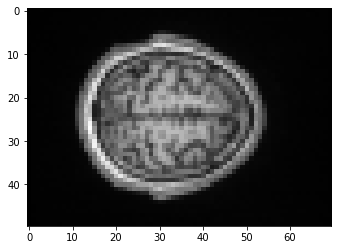

In [9]:
img_gray= a[:,:,180]

#normalizo la imagen
img_o=img_gray
#normalizamos nuestra imagen
img_o=img_o/np.max(img_o) 
#las imagenes se muestran con imshow, con cmap mostramos la escala de grises de la img.
plt.imshow(img_gray, cmap=plt.cm.gray) 

### 5. Aplicamos ruido a nuestras imágenes

Ahora procedemos a aplicar ruido gaussiano a nuestras imágenes. Invocamos del script *modules.py* la función *add_gnoise* con una intensidad de 0.03.

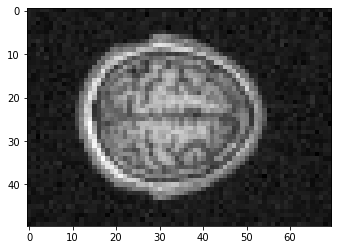

In [10]:
#Aplicar ruido gaussiano

img_gauss=modules.add_gnoise('gauss',img_o,0.03) 
plt.imshow(img_gauss, cmap=plt.cm.gray)

Realizamos el mismo procedimiento, pero esta vez aplicando ruido impulsivo o ruido sal y pimienta a la imagen. Invocamos del script *modules.py* la función *salpimienta* con 0.05 de intensidad.

C:\Users\Maria\Desktop\Universidad\Analisis_Imagen\Practica1\Analisis-main\Analisis\modules.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ruido_output[pos]=1
C:\Users\Maria\Desktop\Universidad\Analisis_Imagen\Practica1\Analisis-main\Analisis\modules.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ruido_output[pos]=0


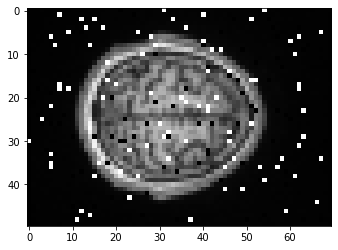

In [11]:
#Aplicar ruido impulsivo

img_salpimienta=modules.salpimienta('s&p',img_o,0.05) 
plt.imshow(img_salpimienta, cmap=plt.cm.gray)

#### 6. Aplicamos el filtro anisotrópico

El filtrado anisotrópico tambien conocido como **filtrado de Perona y Malik**, nos permite suavizar la imagen pero teniendo en cuenta los bordes de la misma. 

En este tipo de filtrado hay que asumir dos condiciones:
   1. **Localización inmediata:** los límites de las regiones deben ser distinguidos y deben coincidir con los originales.
   2. **El suavizado** debe ser mayor dentro de una región que con las regiones vecinas
A diferencia de la difusión anisotrópica, este coeficiente varia segun la localización espacial. 

De esta forma, en las zonas con un **gradiente elevado** la difusión (y el suavizado) será **pequeña**, mientras que en las zonas de **gradiente bajo**, la difusión (y por tanto, el suavizado), será **mayor**. En conclusión, en las zonas de los bordes el suavizado será pequeño y en las zonas más homogéneas de la imagen el suavizado será mayor.


En este caso, no implementaremos el algoritmo de Perona y Malik, si no una **aproximación**:

  1. Aplicamos un **filtro derivativo**:
     * Hemos decidido aplicar el filtro derivativo **Sobel**. Los filtros derivativos son capaces de destacar las zonas con un alto contraste local.Estos filtros funcionan mediante el cálculo del gradiente que, en una imagen sería la diferencia de niveles de gris entre dos puntos de esta. Las zonas con un alto contraste local en una imagen son los bordes
        
         Para propósitos computacionales, vamos a considerar una versión simplificada del gradiente. La magnitud del gradiente  lo calculamos como:
                        |∇f| = |fx | + |fy |
                        
         Sobel es uno de los filtros derivativos mas utilizados, dando mayor peso a los pixeles centrales que a los diagonales.Calculamos las derivadas horizontales y verticales con submascaras de 3x3 y luego sumamos los resultados para obtener el gradiente. 
         
         Es necesario aplicar *padding* para tener en cuenta todos los bordes de nuestra imagen con ruido.
      
2. Recorremos la imagen con parches de 3x3 (operaciones locales): 

    * Tenemos en cuenta el numero de iteraciones por lo que con un bucle while realizamos este procedimiento hasta llegar al numero de iteraciones que metemos como parámetro. 
    * Mediante un bucle for, recorremos nuestra imagen y lo almacenamos en un parche de 3x3. 
    * Calculamos el gradiente. 


3. Mediante un bucle if, y un determinado valor de gradiente (un umbral), decidimos aplicar o no un determinado filtro suavizante, en nuestro caso un filtro de media. 
    * Si el valor del gradiente es mayor que el umbral que hemos determinado, eso quiere decir que el algortimo está iterando sobre una zona donde hay un borde y no aplica el filtrado de media. En el caso de que el gradiente sea menor que el umbral, estamos iterando sobre una zona homogénea y por tanto podemos aplicar el filtro de media en ese parche.

El diagrama a seguir es el siguiente:

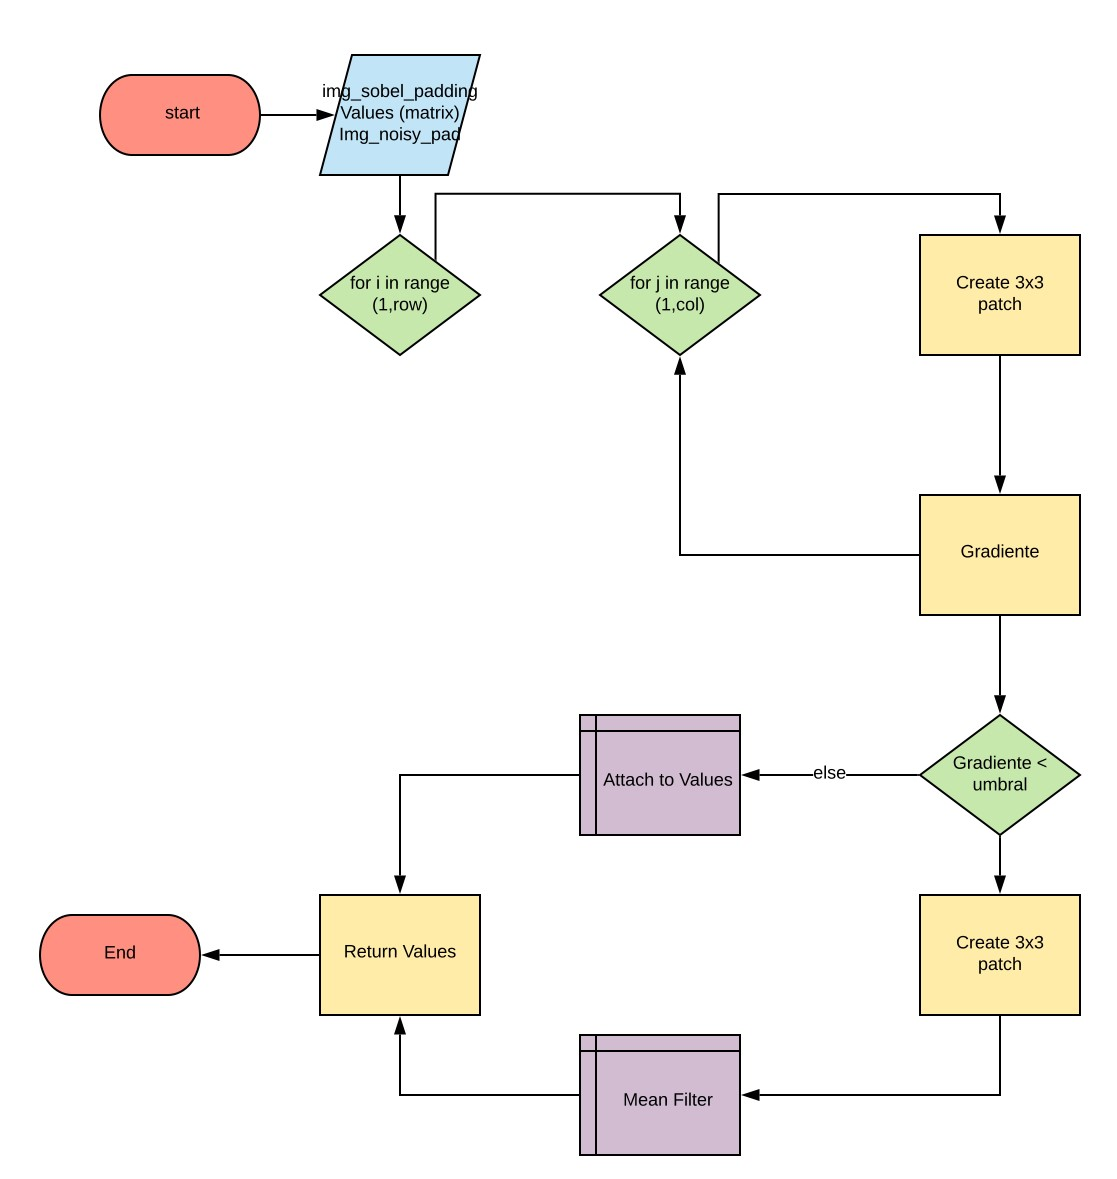

De esta forma importamos la función *aniso_filter* del script *modules.py* y  elegimos un número de iteraciones de 20 y un umbral de 10 con el que ejecutarlo.

In [13]:
#aplicamos el filtro anisotrópico descrito previamente

denoise_img = modules.aniso_filter(img_gauss, 20, 10) 

Una vez aplicado el filtro comparamos la imagen con ruido y la filtrada.

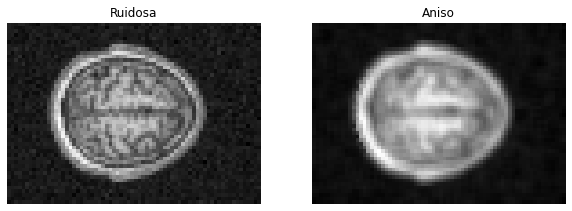

In [14]:
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_gauss,cmap=plt.cm.gray)
plt.title('Ruidosa'), plt.axis('off')
plt.subplot(122)
plt.title('Aniso'), plt.axis('off')
plt.imshow(denoise_img, cmap=plt.cm.gray)

#### 7. Evaluación del filtro anisotrópico con el script de aula virtual 

Una vez aplicado el filtro anisotrópico en el apartado anterior, comparamos su rendimiento con el script facilitado en aula virtual. Para ello primero definimos una función con dicho código:

In [1]:
#Función del filtro anisotrópico del script facilitado en aula virtual 

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),option=1,plot_flag=False):
        """
        Anisotropic diffusion.
 
        Usage:
        imgout = anisodiff(im, niter, kappa, gamma, option)
 
        Arguments:
                img    - input image
                niter  - number of iterations
                kappa  - conduction coefficient 20-100 ?
                gamma  - max value of .25 for stability
                step   - tuple, the distance between adjacent pixels in (y,x)
                option - 1 Perona Malik diffusion equation No 1
                         2 Perona Malik diffusion equation No 2
                plot_flag - if True, the image will be plotted
 
        Returns:
                imgout   - diffused image.
 
        kappa controls conduction as a function of gradient.  If kappa is low
        small intensity gradients are able to block conduction and hence diffusion
        across step edges.  A large value reduces the influence of intensity
        gradients on conduction.
 
        gamma controls speed of diffusion (you usually want it at a maximum of
        0.25)
 
        step is used to scale the gradients in case the spacing between adjacent
        pixels differs in the x and y axes
 
        Diffusion equation 1 favours high contrast edges over low contrast ones.
        Diffusion equation 2 favours wide regions over smaller ones.
 
        Reference:
        P. Perona and J. Malik.
        Scale-space and edge detection using ansotropic diffusion.
        IEEE Transactions on Pattern Analysis and Machine Intelligence,
        12(7):629-639, July 1990.
 
        Original MATLAB code by Peter Kovesi  
        School of Computer Science & Software Engineering
        The University of Western Australia
        pk @ csse uwa edu au
        <http://www.csse.uwa.edu.au>
 
        Translated to Python and optimised by Alistair Muldal
        Department of Pharmacology
        University of Oxford
        <alistair.muldal@pharm.ox.ac.uk>
 
        June 2000  original version.      
        March 2002 corrected diffusion eqn No 2.
        July 2012 translated to Python
        """
 
        # initialize output array
        img = img.astype('float64')
        imgout = img.copy()
 
        # initialize some internal variables
        deltaS = np.zeros_like(imgout)
        deltaE = deltaS.copy()
        NS = deltaS.copy()
        EW = deltaS.copy()
        gS = np.ones_like(imgout)
        gE = gS.copy()    
 
        for ii in range(niter):
 
                # calculate the diffs
                deltaS[:-1,: ] = np.diff(imgout,axis=0)
                deltaE[: ,:-1] = np.diff(imgout,axis=1)
 
                # conduction gradients (only need to compute one per dim!)
                if option == 1:
                        gS = np.exp(-(deltaS/kappa)**2.)/step[0]
                        gE = np.exp(-(deltaE/kappa)**2.)/step[1]
                elif option == 2:
                        gS = 1./(1.+(deltaS/kappa)**2.)/step[0]
                        gE = 1./(1.+(deltaE/kappa)**2.)/step[1]
 
                # update matrices
                E = gE*deltaE
                S = gS*deltaS
 
                # subtract a copy that has been shifted 'North/West' by one
                # pixel. don't as questions. just do it. trust me.
                NS[:] = S
                EW[:] = E
                NS[1:,:] -= S[:-1,:]
                EW[:,1:] -= E[:,:-1]
 
                # update the image
                imgout += gamma*(NS+EW)
 
                               
        if plot_flag:
             # create the plot figure, if requested
            plt.figure(figsize=(12, 5))
            plt.subplot(121)
            plt.imshow(img, cmap=plt.cm.gray)
            plt.title('Original image'), plt.axis('off')
            plt.subplot(122)
            plt.imshow(imgout, cmap=plt.cm.gray)
            plt.title('Filtered image (Anisotropic Diffusion)'), plt.axis('off')
 
        return imgout

In [16]:
aniso= anisodiff(img_gauss)

Una vez aplicado el filtro, comparamos la imagen con ruido y la filtrada. 

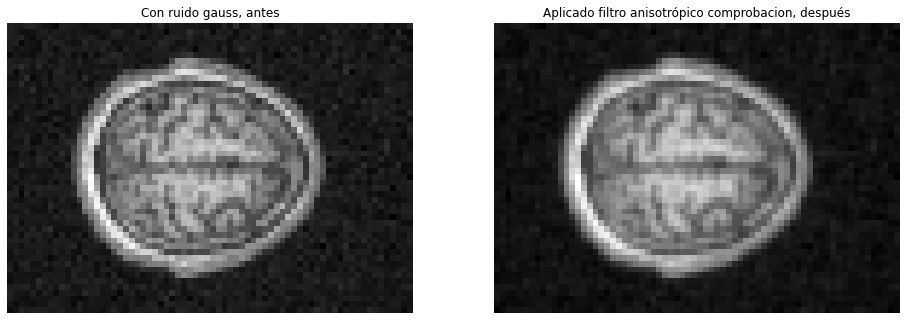

In [17]:
fig = plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img_gauss,cmap=plt.cm.gray)
plt.title('Con ruido gauss, antes'), plt.axis('off')
plt.subplot(122)
plt.title('Aplicado filtro anisotrópico comprobacion, después'), plt.axis('off')
plt.imshow(aniso,cmap=plt.cm.gray)

Como podemos observar en el apartado 6, el rendimiento del filtro anisotrópico nuestro bastante parecido al aplicado en esta sección. Para poder apreciarlo mejor sería una buena idea cambiar los parámetros de iteración y el umbral, además de agrandar la imagen. 